### Figure 1
Script to produce figure 1 of paper "Tracer transport through a submarine canyon"

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib as mpl
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [2]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho

def call_unstag(t):
    UU,VV = rout.unstagger(state.U.isel(T=t),state.V.isel(T=t))
    return(UU,VV)


def call_rho(t,yslice,xslice):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 


In [20]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaFunc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,616))
    Conc = np.empty((19,360,616))
    ConcFiltered = np.empty((19,360,616))
    Area = np.empty((19,360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(616):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                if TrBottom > 0.0:
                    ConcArea[tt,i,j] = TrBottom*ra[i,j]
                    Conc[tt,i,j] = TrBottom
                    Area[tt,i,j] = ra[i,j]
                else:
                    ConcArea[tt,i,j] = np.NaN
                    Conc[tt,i,j] = np.NaN
                    Area[tt,i,j] = np.NaN
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcArea, mask=maskShelf),
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            np.ma.masked_array(Area, mask=maskShelf),
           )

In [4]:
# Alongshelf velocity, Plot1
def Plot1(ax,VV,xslice):
    '''VV is the mean v field, unstaggered, size (nz,ny,nx)
       ax is the corresponding handle for the axis'''
    
    umin = -0.25
    umax = 0.25
    csU = np.linspace(umin,umax,num=20)
    csU2 = np.linspace(umin,umax,num=10)
    
    Uplot = np.ma.array(VV.isel(X=xslice,Yp1=yind).data,mask=MaskC[:,yind,xslice])
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Z[:56],Uplot[:56,:]*100.0,csU*100,cmap=cmo.cm.curl)
    
    cbar_ax = f.add_axes([0.907, 0.552, 0.015, 0.158])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[-25,-20,-15,-10,-5,0,5,10,15,20,25],format='%d')
    cb.ax.yaxis.set_tick_params(pad=1)

    
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.text(0.82,0.1,'v (cm s$^{-1}$)',transform=ax.transAxes)
    ax.text(0.02,0.1,'(d)',transform=ax.transAxes)
    #ax.set_xlabel('Alongshore distance (km)',labelpad=0.0)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


In [5]:
# Isopycnal countours and tracer contourf alongshore
def Plot2(ax,tslice,yslice,xslice):
    
    rho_min = 1020.4-1000.0
    rho_max = 1022.4-1000.0 # 1022.4 if y=230,1021.4 if y=260
    density = call_rho(tslice,yslice,xslice)
    csU2 = np.linspace(rho_min,rho_max,num=11)
    
    tr_min = 0
    tr_max = 22 
    csU = np.linspace(tr_min,tr_max,num=22)
    
    mesh=ax.contourf(grid.X[xslice]/1000,grid.Z[:56],
                      np.ma.array(np.nanmean(ptracers.Tr1[tslice,:56,yslice,xslice].data,axis=0),
                                  mask=MaskC[:56,yind,xslice]),
                      csU,cmap=cmo.cm.matter)
    
    cbar_ax = f.add_axes([0.907, 0.742, 0.015, 0.158])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,3,6,9,12,15,18,21],format='%d')
    cb.ax.yaxis.set_tick_params(pad=1)

        
    CS = ax.contour(grid.X[xslice]/1000,grid.Z[:56],
                     np.ma.array(np.nanmean(density[:,:56,:].data-1000,axis=0),mask=MaskC[:56,yslice,xslice]),
                     csU2,colors='k',linewidths=[0.75] )
    
    manual_locations = [(40, -50), (80, -150), (80, -250),(70,-350)]
    plt.clabel(CS,[csU2[2],csU2[3],csU2[6]],inline=True, fmt='%.1f',inline_spacing=1)
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.text(0.85,0.1,r'C ($\mu$M)',transform=ax.transAxes)
    ax.text(0.02,0.1,r'(b)',transform=ax.transAxes)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


In [6]:
# speed contourf and velocity quiver
def Plot3(ax,UU,VV,zind,xslice,yslice,x_qslice,y_qslice):
    
    Uplot=np.ma.array(UU.isel(Z=zind,Xp1=xslice,Y=yslice).data,mask=MaskC[zind,yslice,xslice])
    Vplot=np.ma.array(VV.isel(Z=zind,X=xslice,Yp1=yslice).data,mask=MaskC[zind,yslice,xslice])
    
    spd = np.sqrt(Uplot**2+Vplot**2)
    
    smin = np.min(spd*100)
    smax= np.max(spd*100)
    
    csU = np.linspace(smin,smax,num=20)
    
    mesh=ax.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,spd[:,:]*100,csU,cmap=cmo.cm.speed)
    
    cbar_ax = f.add_axes([0.907, 0.358, 0.015, 0.162])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,5,10,15,20,25,30,35,40,45],format='%d')
    cb.ax.yaxis.set_tick_params(pad=1)
    
    Q = ax.quiver(grid.X[x_qslice]/1000,
                  grid.Y[y_qslice]/1000, 
                  Uplot[::15,::15], 
                  Vplot[::15,::15], color=(255/255,69/255,0/255),
                  angles='xy', scale_units='xy', scale=0.05)
    qk = ax.quiverkey(Q, 0.1, 0.95, 0.5, r'$50 \frac{cm}{s}$',
                   labelpos='S',
                   coordinates='axes',
                   fontproperties={'weight': 'bold'})
     
    SB = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     grid.Depth[yslice,xslice],
                    [150.0],
                    colors='0.8',linewidths=[0.75] )
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('CS distance (km)',labelpad=0.0)
    ax.text(0.65,0.9,' Speed (cm s$^{-1}$)     (f)',transform=ax.transAxes)
    #ax.text(0.9,0.9,' (f)',transform=ax.transAxes)
    ax.set_aspect(1)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


In [7]:
# Cross-shelf U
def Plot4(ax,UU,xind,yslice):
    
    umin = -50
    umax= 50
    
    Uplot=np.ma.array(UU.isel(Xp1=xind,Y=yslice).data,mask=MaskExpand[14,:,yslice,xind])
    csU = np.linspace(umin,umax,num=20)
    csU2 = np.linspace(umin,umax,num=10)
    
    mesh=ax.contourf(grid.Y[yslice]/1000,grid.Z[:56],Uplot[:56,:]*100,csU,cmap=cmo.cm.curl)
    
    cbar_ax = f.add_axes([0.42, 0.552, 0.015, 0.158])
    cb=f.colorbar(mesh, cax=cbar_ax,orientation='vertical',ticks=[-50,-25,0,25,50],format='%d')
    cb.ax.yaxis.set_tick_params(pad=1)
    
    ax.plot(grid.Y[230:251]/1000,(grid.RC[20].data)*np.ones(np.shape(grid.Y[230:251])),color='0.5')
    ax.plot(grid.Y[230:251]/1000,(grid.RC[16].data)*np.ones(np.shape(grid.Y[230:251])),color='0.5')
    ax.plot(((grid.Y[230]/1000).data)*np.ones(np.shape(grid.RC[16:21])),grid.RC[16:21],color='0.5')
    ax.plot(((grid.Y[250]/1000).data)*np.ones(np.shape(grid.RC[16:21])),grid.RC[16:21],color='0.5')

    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    #ax.text(0.8,0.1,'u (cm s$^{-1}$)',transform=ax.transAxes)
    ax.text(0.61,0.1,'u (cm s$^{-1}$)    (c)',transform=ax.transAxes)
    
    ax.set_xlabel('CS distance (km)',labelpad=0.01)
    ax.set_ylabel('Depth (m)',labelpad=0.0)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


In [8]:
##### Incoming U
def Plot5(ax,UU,xind,yslice,zslice,tslice):
    
    Uplot=np.nanmean(np.nanmean(np.ma.array(UU.isel(Xp1=xind,Y=yslice,Z=zslice).data,
                                            mask=MaskExpand[tslice,zslice,yslice,xind]),axis=1),axis=1)
    ax.plot(np.arange(19)/2.0,Uplot,color='0.4')
    plt.yticks( [0.00,0.10,0.20,0.30], ('0.0', '0.1', '0.2', '0.3', '0.4') )      
    ax.set_ylabel(r'u (ms$^{-1}$)',labelpad=0.3)
    #ax.set_xlabel('Days',labelpad=0.3)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.text(0.9,0.1,'(e)',transform=ax.transAxes)
    ax.set_aspect(10)

In [9]:
# Isopycnal countours and tracer contourf cross-shore
def Plot6(ax,tslice,yslice,xslice):
    
    rho_min = 1020.4-1000
    rho_max = 1022.4-1000 
    density = call_rho(tslice,yslice,xslice)
    csU2 = np.linspace(rho_min,rho_max,num=11)
    
    tr_min = 0
    tr_max = 22
    csU = np.linspace(tr_min,tr_max,num=20)
    
    mesh=ax.contourf(grid.Y[yslice]/1000,grid.Z[:56],
                      np.ma.array(np.nanmean(ptracers.Tr1[tslice,:56,yslice,xslice].data,axis=0),
                                  mask=MaskC[:56,yslice,xslice]),
                      csU,cmap=cmo.cm.matter)
    
    cbar_ax = f.add_axes([0.42, 0.742, 0.015, 0.158])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,3,6,9,12,15,18,21],format='%d')
    cb.ax.yaxis.set_tick_params(pad=1)

        
    CS = ax.contour(grid.Y[yslice]/1000,grid.Z[:56],
                     np.ma.array(np.nanmean(density[:,:56,:].data-1000,axis=0),mask=MaskC[:56,yslice,xslice]),
                     csU2,colors='k',linewidths=[0.75] )
    plt.clabel(CS,inline=True, fmt='%.1f')
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.text(0.68,0.1,r'C ($\mu$M)    (a)',transform=ax.transAxes)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    #ax.text(0.95,0.1,r'(a)',transform=ax.transAxes)
    ax.set_ylabel('Depth (m)',labelpad=0.0)
    
    

    

In [10]:
# BAC colormap
def Plot8(ax,ConcFilt,tslice,xslice,yslice):
    
    BAC = np.nanmean(ConcFilt[tslice,yslice,xslice],axis=0)
    
    maxCM = np.max(BAC)
    minCM = np.min(BAC)
    
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,BAC,21, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmo.cm.tempo)
    
    cbar_ax = f.add_axes([0.907, 0.130, 0.015, 0.20])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[2.2,3.2,4.2,5.2,6.2,7.2,8.2,9.2,10.2],format='%.1f')
    cb.ax.yaxis.set_tick_params(pad=1)
   
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    
    ax.text(0.85,0.9,'C ($\mu$M)',transform=ax.transAxes)
    SB = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     grid.Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.set_xlabel('Alongshelf distance (km)',labelpad=0.3)
    ax.set_ylabel('CS distance (km)',labelpad=0.3)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    ax.text(0.02,0.9,'(h)',transform=ax.transAxes)
    

In [11]:
# Mean BAC
def Plot9(ax,ConcArea,Area,tslice,xslice,yslice):
    
    AA = np.sum(np.sum(Area[tslice,yslice,xslice],axis=1),axis=1)
    BAC = (np.nansum(np.nansum(ConcArea[tslice,yslice,xslice],axis=1),axis=1))/AA[0]
           
    ax.plot(np.arange(19)/2.0,BAC,color='0.4')
    plt.yticks( [5.0,6.0,7.0,8.0], ('5.0', '6.0', '7.0', '8.0') )    
    ax.set_ylabel('BAC ($\mu$M)',labelpad=0.3)
    ax.set_xlabel('Days',labelpad=0.3)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.text(0.9,0.1,'(g)',transform=ax.transAxes)
    ax.set_aspect(1.2)

In [13]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_n/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_n/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_n/run38/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [14]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

yind = 230 # y index for alongshore cross-section
#yind2 = 250 # y index for alongshore cross-section

xslice=slice(0,360)
yslice=slice(100,300)

xslice_spd = slice(60,300)
yslice_spd = slice(150,280)

x_qslice = slice(60,300,15)
y_qslice = slice(150,280,15)

tslice = slice(6,10)

xind = 180
yslice_u = slice(150,300)
zind = 27

# plot 5
xind_umean = 120
yslice_umean = slice(150,267)
zslice_umean = slice(25,50)
tslice_umean = slice(0,19)

# plot 6
yslice_bac_2d = slice(225,350)
yslice_bac = slice(225,300)
xslice_bac = slice(100,360)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

MaskExpand = np.expand_dims(MaskC,0) 
MaskExpand = MaskExpand + np.zeros((ptracers.Tr1).shape)    

In [15]:
UU,VV = call_unstag(10)
UU_mean,VV_mean = call_unstag(tslice_umean)

In [21]:
ConcArea, ConcFilt, Area = ConcAreaFunc(ptracers.Tr1.data, 
                                        grid.HFacC.data, 
                                        grid.rA.data, 
                                        grid.Depth.data)

(360, 616)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(19, 360, 616)


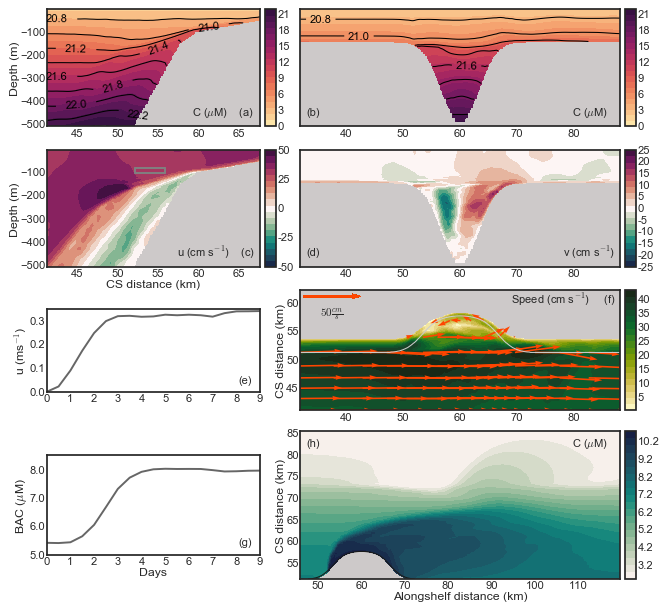

In [22]:
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 8.0

f = plt.figure(figsize = (7.4,7.4)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(2, 1, height_ratios=[1,1.2],hspace=0.02,wspace=0.05)

gs0 = gspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0],hspace=0.2, wspace=0.15,width_ratios=[1,1.5],height_ratios=[1,1])
gs1 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],hspace=0.15,wspace=0.15,width_ratios=[1,1.5])
gs10 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs1[1],hspace=0.0,wspace=0.15,height_ratios=[1.0,1])
gs11 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs1[0],hspace=0.0,wspace=0.15,height_ratios=[1,1])

ax1 = plt.subplot(gs0[1,1],yticks=[])
Plot1(ax1,VV,xslice_spd) # v alongshelf section

ax2 = plt.subplot(gs0[0,1],yticks=[])
Plot2(ax2,tslice,yind,xslice_spd) # isopyc alongshelf section

ax3 = plt.subplot(gs10[0])
Plot3(ax3,UU,VV,zind,xslice_spd,yslice_spd,x_qslice,y_qslice) # speeds and quiver

ax4 = plt.subplot(gs0[1,0])
Plot4(ax4,UU,xind,yslice_u) # u cross-shelf section

ax5 = plt.subplot(gs11[0])
Plot5(ax5,UU_mean,xind_umean,yslice_umean,zslice_umean,tslice_umean)

ax6 = plt.subplot(gs0[0,0])
Plot6(ax6,tslice,yslice_u,xind)

ax8 = plt.subplot(gs10[1])
Plot8(ax8,ConcFilt,tslice,xslice_bac,yslice_bac_2d)

ax9 = plt.subplot(gs11[1])
Plot9(ax9,ConcArea,Area,tslice_umean,xslice_bac,yslice_bac)

#plt.tight_layout()

plt.savefig('figure2.eps',format='eps',bbox_inches='tight')


### CNTDIFF_LOW_SR (sr = 0.10, instead of 0.15)

In [51]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR/run01/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)


In [39]:
UU,VV = call_unstag(10)
UU_mean,VV_mean = call_unstag(tslice_umean)

ConcArea, ConcFilt, Area = ConcAreaFunc(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(19, 360, 360)


(19,)


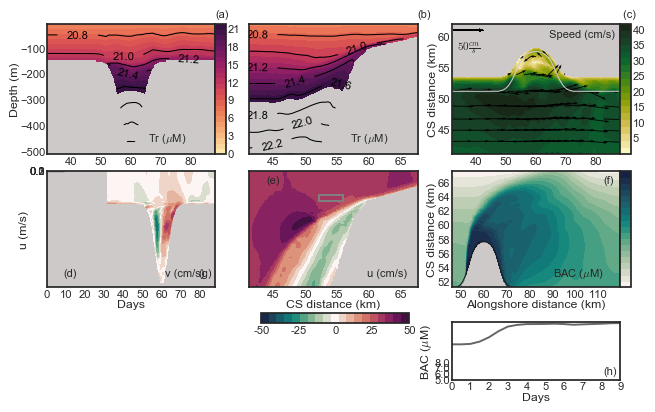

In [40]:
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 8.0

f = plt.figure(figsize = (7.4,4.6)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 3, height_ratios=[1,1.6],hspace=0.1,wspace=0.2)
gs10 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1,0],height_ratios=[3,1.5],hspace=0.4)
gs11 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1,1],height_ratios=[3,1.5],hspace=0.4)
gs12 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1,2],height_ratios=[3,1.5],hspace=0.4)

Plot1(gs10,VV,xslice_spd) # v alongshelf section

Plot2(gs0,tslice,yind,xslice_spd) # isopyc alongshelf section

Plot3(gs0,UU,VV,zind,xslice_spd,yslice_spd,x_qslice,y_qslice) # speeds and quiver

Plot4(gs11,UU,xind,yslice_u) # u cross-shelf section

Plot5(gs10,UU_mean,xind_umean,yslice_umean,zslice_umean,tslice_umean)

Plot6(gs0,tslice,yslice_u,xind)

Plot8(gs12,ConcFilt,tslice,xslice_bac,yslice_bac)

Plot9(gs12,ConcFilt,tslice_umean,xslice_bac,yslice_bac)

#plt.tight_layout()

plt.savefig('fig1_FlowCharacteristicsLOW_SR.eps',format='eps',bbox_inches='tight')


### CNTDIFF_LOWER_SR (sr = 0.07, instead of 0.15)

In [26]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOWER_SR_7Tr/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOWER_SR_7Tr/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOWER_SR_7Tr/run01/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)


In [27]:
UU,VV = call_unstag(10)
UU_mean,VV_mean = call_unstag(tslice_umean)

ConcArea, ConcFilt, Area = ConcAreaFunc(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(19, 360, 360)


(19,)


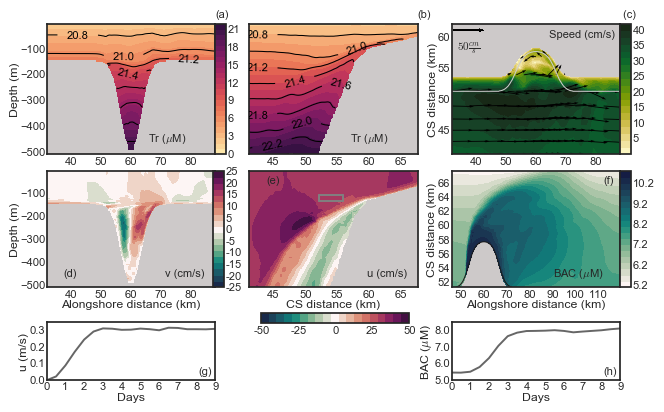

In [56]:
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 8.0

f = plt.figure(figsize = (7.4,4.6)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 3, height_ratios=[1,1.6],hspace=0.1,wspace=0.2)
gs10 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1,0],height_ratios=[3,1.5],hspace=0.4)
gs11 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1,1],height_ratios=[3,1.5],hspace=0.4)
gs12 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1,2],height_ratios=[3,1.5],hspace=0.4)

Plot1(gs10,VV,xslice_spd) # v alongshelf section

Plot2(gs0,tslice,yind,xslice_spd) # isopyc alongshelf section

Plot3(gs0,UU,VV,zind,xslice_spd,yslice_spd,x_qslice,y_qslice) # speeds and quiver

Plot4(gs11,UU,xind,yslice_u) # u cross-shelf section

Plot5(gs10,UU_mean,xind_umean,yslice_umean,zslice_umean,tslice_umean)

Plot6(gs0,tslice,yslice_u,xind)

Plot8(gs12,ConcFilt,tslice,xslice_bac,yslice_bac)

Plot9(gs12,ConcFilt,tslice_umean,xslice_bac,yslice_bac)

#plt.tight_layout()

plt.savefig('fig1_FlowCharacteristicsLOWER_SR.eps',format='eps',bbox_inches='tight')


## Talk version

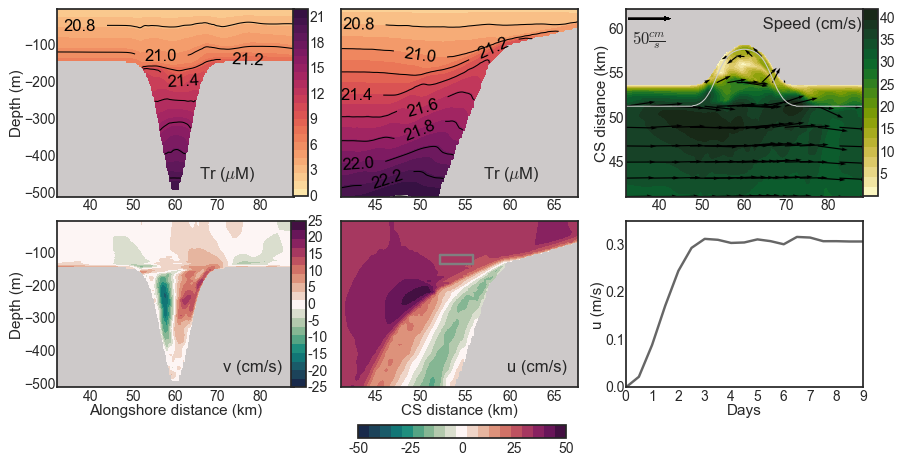

In [66]:
sns.set_context('notebook')
sns.set_style('white')

plt.rcParams['font.size'] = 12.0

f = plt.figure(figsize = (10.4,6.6)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 3, height_ratios=[1,1.6],hspace=0.1,wspace=0.2)
gs10 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1,0],height_ratios=[3,1.5],hspace=0.4)
gs11 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1,1],height_ratios=[3,1.5],hspace=0.4)
gs12 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1,2],height_ratios=[3,1.5],hspace=0.4)

Plot1(gs10,VV,xslice_spd) # v alongshelf section

Plot2(gs0,tslice,yind,xslice_spd) # isopyc alongshelf section

Plot3(gs0,UU,VV,zind,xslice_spd,yslice_spd,x_qslice,y_qslice) # speeds and quiver

Plot4(gs11,UU,xind,yslice_u) # u cross-shelf section

Plot5(gs12,UU_mean,xind_umean,yslice_umean,zslice_umean,tslice_umean)

Plot6(gs0,tslice,yslice_u,xind)



#plt.tight_layout()

plt.savefig('fig1_FlowCharacteristicsLOWER_SR_Talk.eps',format='eps',bbox_inches='tight')
